In [4]:
import logging
import sys

import pandas as pd

from hamilton import base, driver
from hamilton.io.materialization import to
from hamilton import ad_hoc_utils

logging.basicConfig(stream=sys.stdout)

In [2]:
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1
# import the function modules you want to reload when they change.
# i.e. these should be your modules you write your functions in. As you change them,
# they will be reimported without you having to do anything.
%aimport my_functions

In [5]:
#   Define your new Hamilton functions & curate them into a TemporaryFunctionModule object.
# This enables you to add functions to your DAG without creating a proper module.

# Look at `my_functions` to see how these functions connect.
def signups() -> pd.Series:
    """Returns sign up values"""
    return pd.Series([1, 10, 50, 100, 200, 400])


def spend() -> pd.Series:
    """Returns the spend values"""
    return pd.Series([10, 10, 20, 40, 40, 50])


def log_spend_per_signup(spend_per_signup: pd.Series) -> pd.Series:
    """Simple function taking the logarithm of spend over signups."""
    return np.log(spend_per_signup)


# Place the functions into a temporary module -- the idea is that this should house a curated set of functions.

temp_module = ad_hoc_utils.create_temporary_module(
    spend, signups, log_spend_per_signup, module_name="function_example"
)

In [6]:
initial_columns = {  # load from actuals or wherever -- this is our initial data we use as input.
    # Note: these values don't have to be all series, they could be a scalar.
    "signups": pd.Series([1, 10, 50, 100, 200, 400]),
    "spend": pd.Series([10, 10, 20, 40, 40, 50]),
}

In [7]:
df_builder = base.PandasDataFrameResult()

dr = driver.Driver({}, my_functions)  # can pass in multiple modules

In [19]:
# we need to specify what we want in the final dataframe. These can be string names, or function references.
output_columns = [
    "spend",
    "signups",
    my_functions.avg_3wk_spend,  # could just pass "avg_3wk_spend" here
    my_functions.spend_per_signup,  # could just pass "spend_per_signup" here
    my_functions.spend_zero_mean_unit_variance,  # could just pass "spend_zero_mean_unit_variance" here
]

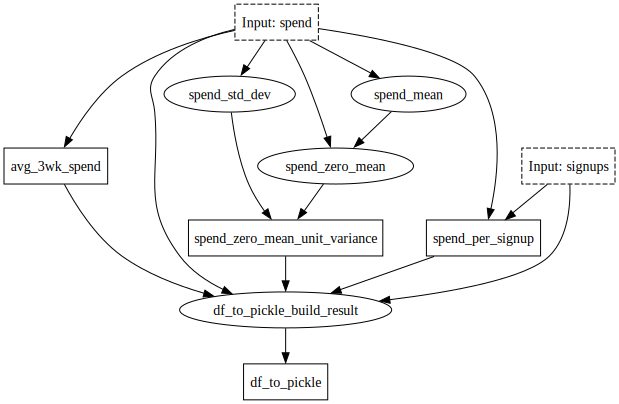

In [17]:
materializers = [
    # materialize the dataframe to a pickle file
    to.pickle(
        dependencies=output_columns,
        id="df_to_pickle",
        path="./df.pkl",
        combine=df_builder,
    ),
]
# Visualize what is happening
dr.visualize_materialization(
    *materializers,
    additional_vars=output_columns,
    inputs=initial_columns,
)

In [20]:
# Materialize a result, i.e. execute the DAG!
materialization_results, additional_outputs = dr.materialize(
    *materializers,
    additional_vars=[
        "df_to_pickle_build_result"
    ],  # because combine is used, we can get that result here.
    inputs=initial_columns,
)

In [21]:
materialization_results


{'df_to_pickle': {'size': 1088,
  'path': './df.pkl',
  'last_modified': 1694149106.5754302,
  'timestamp': 1694174306.575576}}

In [22]:
additional_outputs["df_to_pickle_build_result"]

spend  signups  avg_3wk_spend  spend_per_signup  \
0     10        1            NaN            10.000   
1     10       10            NaN             1.000   
2     20       50      13.333333             0.400   
3     40      100      23.333333             0.400   
4     40      200      33.333333             0.200   
5     50      400      43.333333             0.125   

   spend_zero_mean_unit_variance  
0                      -1.064405  
1                      -1.064405  
2                      -0.483821  
3                       0.677349  
4                       0.677349  
5                       1.257934